# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Probabilistic reformulation of a linear regression

</font>
</div>

# Probabilistic reformulation of a linear regression
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>


- A linear regression problem is formulated as follows:

$$ Y = X\beta + \epsilon $$

- where $Y$ is the output we want to predict (or *dependent* variable), $X$ is our predictor (or *independent* variable), and $\beta$ are the coefficients (or parameters) of the model we want to estimate. $\epsilon$ is an error term which is assumed to be normally distributed. We can then use ordinary least squares (OLS) or maximum likelihood to find the best fitting $\beta$.

- Bayesians take a probabilistic view of the the same problem which can be reformulated as:

$$ Y \sim \mathcal{N}(X \beta, \sigma^2) $$

- $Y$ as a random variable (or random vector) of which each element (data point) is distributed according to a Normal distribution. The mean of this normal distribution is provided by our linear predictor with variance $\sigma^2$.

- While this is essentially the same model, there are two critical advantages of Bayesian estimation:
     - Priors: We can quantify any prior knowledge we might have by placing priors on the paramters. For example, if we think that $\sigma$ is likely to be small we would choose a prior with more probability mass on low values.
     - Quantifying uncertainty: We do not get a single estimate of $\beta$ as above but instead a complete posterior distribution about how likely different values of $\beta$ are. For example, with few data points our uncertainty in $\beta$ will be very high and we'd be getting very wide posteriors.
     
</font>
</div>
     

# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from pymc import HalfCauchy, Model, Normal, sample
import bambi as bmb

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Generate data
<hr style = "border:2px solid black" ></hr>

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x

# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

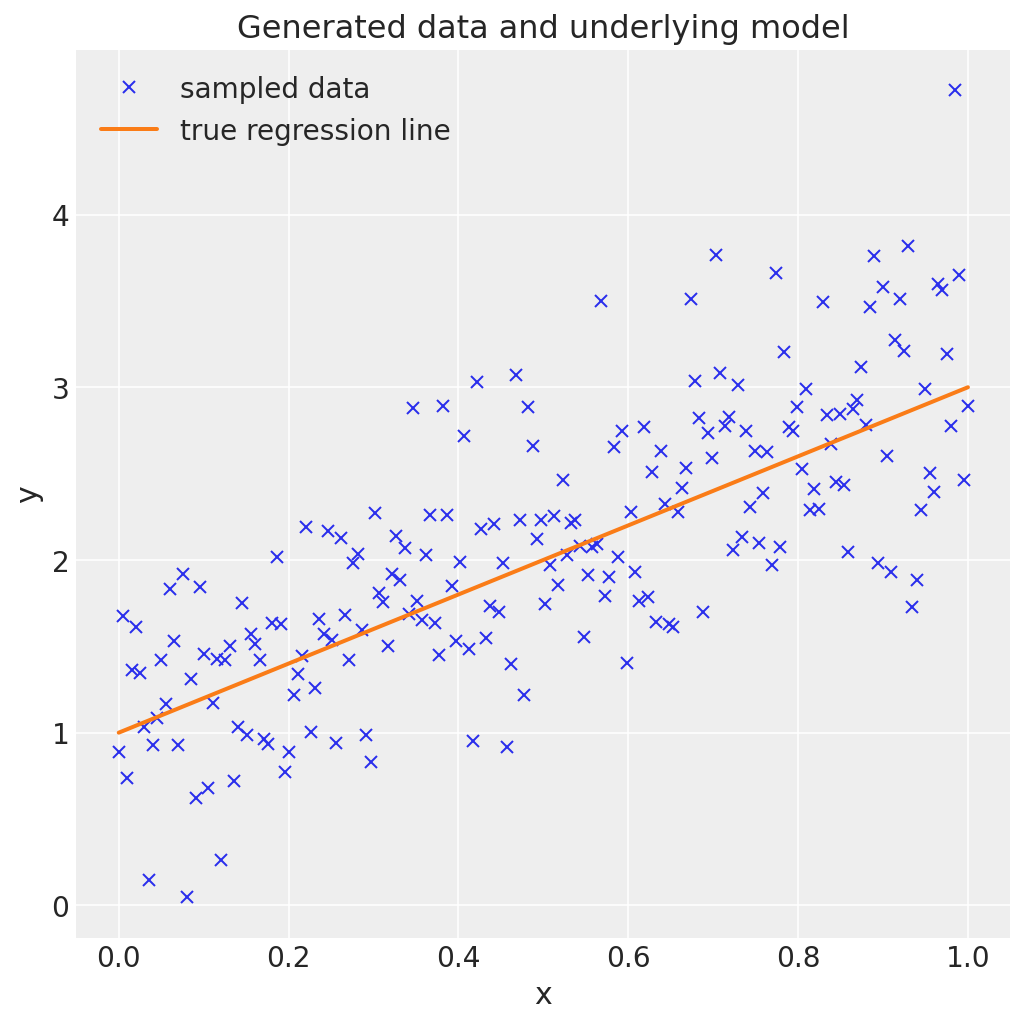

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

# Bayesian linear regression
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- Lets fit a Bayesian linear regression model to this data. 
- In PyMC, the model specifications takes place in a `with` expression, called a context manager. 
- By default, models are fit using the NUTS sampler], resulting in a trace of samples representing the marginal posterior distribution of the latent model parameters.
    
</font>
</div>

In [5]:
# model specifications in PyMC are wrapped in a with-statement
with Model() as model:
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference - draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 23 seconds.


# Modelling the same with `bambi`
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- To make things even simpler, the `bambi` library  takes a formula linear model specifier from which it creates a design matrix.
- `bambi` then adds random variables for each of the coefficients and an appopriate likelihood to the model. 
- If `bambi` is not installed, you can install it with `pip install bambi`.
- Much shorter, but this code does the exact same thing as the previous specification (you can change priors and everything else too if we wanted). `bambi` parses the `formulae` model string, adds random variables for each regressor (`Intercept` and slope `x` in this case), adds a likelihood (by default, a Normal is chosen), and all other variables (`sigma`). Finally, `bambi` then initializes the parameters to a good starting point by estimating a frequentist linear model using `statsmodels`.
- If you are not familiar with R's syntax, `'y ~ x'` specifies that we have an output variable `y` that we want to estimate as a linear function of `x`.

</font>
</div>

In [6]:
model_ = bmb.Model("y ~ x", data)
idata_ = model_.fit(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, y_sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 21 seconds.


# Analysing the model
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- Bayesian inference does not give us only one line of best fit (**as maximum likelihood does**) but rather a whole 
posterior distribution of plausible parameters. 

- Lets plot the **posterior distribution** of our parameters and the individual samples we drew.

- The left side shows our marginal posterior -- for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

- There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem homogeneous and stationary (there are no large drifts or other odd patterns).

- Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (`x` is the regression coefficient and `sigma` is the standard deviation of our normal).
   
</font>
</div>

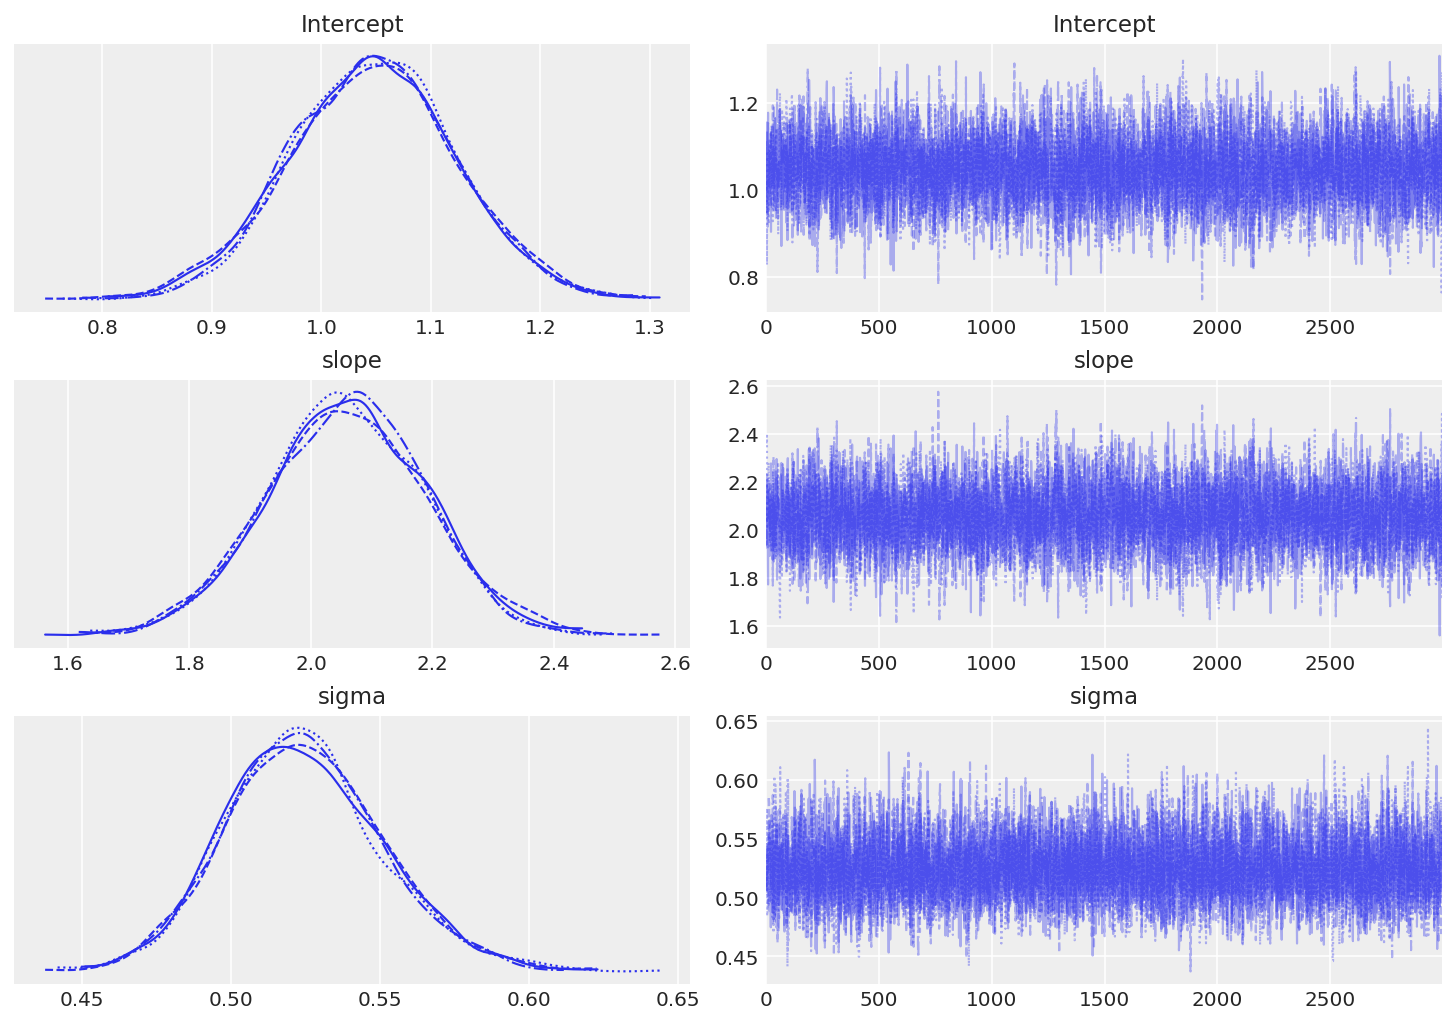

In [7]:
az.plot_trace(idata, figsize=(10, 7));

# Inference
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- As you can see, our estimated regression lines are very similar to the true regression line. 
- But since we only have limited data we have *uncertainty* in our estimates, here expressed by the variability of the lines.
    
</font>
</div>

In [11]:
# We can manually generate these regression lines using the posterior samples directly.
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["slope"] * xr.DataArray(x)

/opt/anaconda3/envs/ML4T/lib/python3.10/site-packages/arviz/plots/lmplot.py:209: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)
/opt/anaconda3/envs/ML4T/lib/python3.10/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


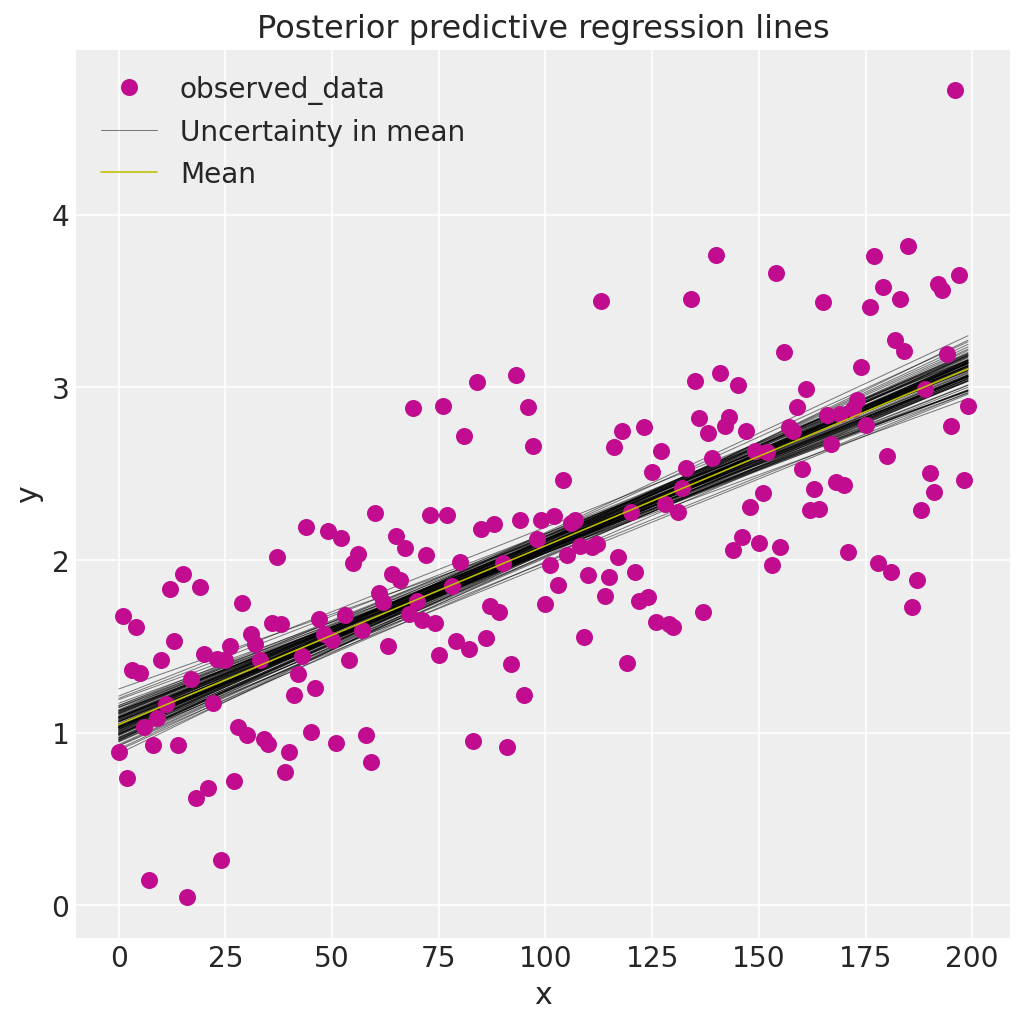

In [12]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");

# Conclusions
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-danger">
<font color=black>

- Usability is currently a huge hurdle for wider adoption of Bayesian statistics.
- `Bambi` allows GLM specification with convenient syntax borrowed from R. Inference can then be carried out with `pymc`.
- Posterior predictive plots allow us to evaluate fit and our uncertainty in it.

</font>
</div>

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html

</font>
</div>

# Requiremetns
<hr style = "border:2px solid black" ></hr>

In [13]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

bambi     : 0.9.1
arviz     : 0.12.1
json      : 2.0.9
matplotlib: 3.5.3
pandas    : 1.4.4
pymc      : 4.1.7
numpy     : 1.21.6
xarray    : 2022.6.0
autopep8  : 1.7.0

